In [141]:
import csv
import sys
import pickle
import random
import pandas as pd
from dataclasses import dataclass
from collections import defaultdict, Counter
from typing import Mapping, List, Set, Tuple

In [18]:
# Define a Task dataclass for storage of Task information.
@dataclass
class Task:
    name: str
    job: str
    instances: int
    status: str
    start_time: float
    end_time: float
    expected_duration: float
    actual_duration: float
    cpu_requested: float
    cpu_usage: float
    mem_requested: float
    mem_usage: float

In [2]:
batch_task_data = pd.read_csv(
    "./data/batch_task.csv",
    header=None,
    names=["task_name", "instance_num", "job_name", "task_type", "status", "start_time", "end_time", "plan_cpu", "plan_mem"]
)
print("[x] Loaded {} DAGs from the CSV.".format(len(batch_task_data)))

[x] Loaded 14295731 DAGs from the CSV.


In [19]:
job_names_to_tasks: Mapping[str, List[Task]] = defaultdict(list)
num_rows = len(batch_task_data)
output_frequency = len(batch_task_data) / 20
for index, row in batch_task_data.iterrows():
    job_names_to_tasks[row.job_name].append(
        Task(
            name=row.task_name,
            job=row.job_name,
            instances=row.instance_num,
            status=row.status,
            start_time=row.start_time,
            end_time=row.end_time,
            expected_duration=(row.end_time - row.start_time),
            actual_duration=(row.end_time - row.start_time),
            cpu_requested=row.plan_cpu,
            cpu_usage=row.plan_cpu,
            mem_requested=row.plan_mem,
            mem_usage=row.plan_mem))
    if index % output_frequency == 0:
        print(f"[x] Processed {index} / {num_rows} rows and retrieved {len(job_names_to_tasks)} job definitions.")

[x] Processed 0 / 14295731 rows and retrieved 1 job definitions.


In [32]:
# Mapping of (task_name, job_name) to a list of [duration, cpu_usage, mem_usage, num_instances]
# We use this to aggregate statistics about each task of all the jobs, and will then merge it with
# the tasks created above.
job_task_statistics: Mapping[Tuple[str, str], List[int]] = defaultdict(lambda: [0, 0, 0, 0])
with open('data/batch_instance.csv', 'r') as batch_instance:
    datareader = csv.reader(batch_instance)
    counter = 0
    for row in datareader:
        if not row[1][1].isdigit() or row[4] != "Terminated":
            continue
            
        duration = None
        cpu_usage = None
        mem_usage = None
        try:
            # Add duration statistics.
            duration = int(row[6]) - int(row[5])
            # Add CPU statistics
            cpu_usage = float(row[10])
            # Add memory statistics.
            mem_usage = float(row[12])
            # Append the number of observations made.
            stats_for_this_task[3] += 1
        except ValueError as e:
            continue
            
        # Add to the statistics if everything works.
        stats_for_this_task = job_task_statistics[(row[2], row[1])]
        stats_for_this_task[0] += duration
        stats_for_this_task[1] += cpu_usage
        stats_for_this_task[2] += mem_usage
        stats_for_this_task[3] += 1
        
        counter += 1
        if counter % 1e7 == 0:
            print(f"[x] Finished processing {counter} rows and have results for {len(job_task_statistics)} tasks.")

[x] Finished processing 10000000 rows and have results for 94972 tasks.
[x] Finished processing 20000000 rows and have results for 192431 tasks.
[x] Finished processing 30000000 rows and have results for 288936 tasks.
[x] Finished processing 40000000 rows and have results for 384740 tasks.
[x] Finished processing 50000000 rows and have results for 481181 tasks.
[x] Finished processing 60000000 rows and have results for 578491 tasks.
[x] Finished processing 70000000 rows and have results for 672802 tasks.
[x] Finished processing 80000000 rows and have results for 768920 tasks.
[x] Finished processing 90000000 rows and have results for 866965 tasks.
[x] Finished processing 100000000 rows and have results for 965765 tasks.
[x] Finished processing 110000000 rows and have results for 1060606 tasks.
[x] Finished processing 120000000 rows and have results for 1157846 tasks.
[x] Finished processing 130000000 rows and have results for 1253015 tasks.
[x] Finished processing 140000000 rows and ha

In [40]:
counter = 0
for job_name, tasks in job_names_to_tasks.items():
    for task in tasks:
        key = (job_name, task.name)
        if key in job_task_statistics:
            duration, cpu_usage, mem_usage, num_samples = job_task_statistics[key]
            if num_samples == 0:
                continue
            task.actual_duration = float(duration) / num_samples
            task.cpu_usage = cpu_usage / num_samples
            task.mem_usage = mem_usage / num_samples
            if counter % 20000 == 0:
                print(f'[x] Finished processing {counter} samples from {len(job_task_statistics)} tasks.')
            counter += 1

[x] Finished processing 0 samples from 11895518 tasks.
[x] Finished processing 20000 samples from 11895518 tasks.
[x] Finished processing 40000 samples from 11895518 tasks.
[x] Finished processing 60000 samples from 11895518 tasks.
[x] Finished processing 80000 samples from 11895518 tasks.
[x] Finished processing 100000 samples from 11895518 tasks.
[x] Finished processing 120000 samples from 11895518 tasks.
[x] Finished processing 140000 samples from 11895518 tasks.
[x] Finished processing 160000 samples from 11895518 tasks.
[x] Finished processing 180000 samples from 11895518 tasks.
[x] Finished processing 200000 samples from 11895518 tasks.
[x] Finished processing 220000 samples from 11895518 tasks.
[x] Finished processing 240000 samples from 11895518 tasks.
[x] Finished processing 260000 samples from 11895518 tasks.
[x] Finished processing 280000 samples from 11895518 tasks.
[x] Finished processing 300000 samples from 11895518 tasks.
[x] Finished processing 320000 samples from 11895

In [90]:
# Filter out the DAGs that do not have the dependency information.
filtered_dags: Set[str] = set()
counter = 0
for job_name, tasks in job_names_to_tasks.items():
    counter += 1
    is_filtered = False
    for task in tasks:
        if not task.name[1].isdigit() or task.status != "Terminated" or 'Stg' in task.name:
            is_filtered = True
            break
    if is_filtered:
        filtered_dags.add(job_name)
    if counter % 1e6 == 0:
        print(f'[x] Processed {counter} jobs from {len(job_names_to_tasks)} jobs.')

[x] Processed 1000000 jobs from 4201014 jobs.
[x] Processed 2000000 jobs from 4201014 jobs.
[x] Processed 3000000 jobs from 4201014 jobs.
[x] Processed 4000000 jobs from 4201014 jobs.


In [103]:
# Find the entire set of DAGs that need to be written to the pickle files.
jobs_to_pickle: Set[str] = set()
for job_name in job_names_to_tasks.keys():
    if job_name not in filtered_dags:
        jobs_to_pickle.add(job_name)

In [104]:
print(f'[x] A total of {len(jobs_to_pickle)} DAGs were extracted from a total of {len(job_names_to_tasks)} available DAGs.') 

[x] A total of 3141545 DAGs were extracted from a total of 4201014 available DAGs.


In [120]:
# Find all the straight chain DAGs in the system.
straight_chain_dags: Set[str] = set()
for job_name in jobs_to_pickle:
    is_straight_chain_dag = True
    visited_parents: Set[str] = set()
    for task in job_names_to_tasks[job_name]:
        if len(task.name.split('_')) > 2:
            is_straight_chain_dag = False
            break
        parent_task = task.name[1]
        if parent_task in visited_parents:
            is_straight_chain_dag = False
            break
        visited_parents.add(parent_task)
        
    if is_straight_chain_dag:
        straight_chain_dags.add(job_name)

In [121]:
# Find the length of the straight chain DAGs.
straight_chain_dag_length: Mapping[int, List[str]] = defaultdict(list)

for job_name in straight_chain_dags:
    job_tasks = job_names_to_tasks[job_name]
    straight_chain_dag_length[len(job_tasks)].append(job_name)

In [125]:
print(f'[x] Found a total of {len(straight_chain_dags)} straight chain DAGs with the lengths: {straight_chain_dag_length.keys()}')

[x] Found a total of 2253617 straight chain DAGs with the lengths: dict_keys([1, 2, 8, 3, 4, 5, 6, 9, 7])


In [129]:
_rng = random.Random()
_rng.seed(42)

def split_into_sets(job_names: Set[str], num_sets: int = 500) -> List[Set[str]]:
    split_sets = [set() for _ in range(num_sets)]
    for job_name in job_names:
        chosen_set = _rng.choice(split_sets)
        chosen_set.add(job_name)
    return split_sets

In [145]:
filtered_dag_splits = split_into_sets(filtered_dags, num_sets=150)

In [146]:
min_length = sys.maxsize
max_length = 0
for split_set in filtered_dag_splits:
    set_length = len(split_set)
    if set_length < min_length:
        min_length = set_length
    if set_length > max_length:
        max_length = set_length

print(f'[x] Created {len(filtered_dag_splits)} sets with size range between {min_length} and {max_length}.')

[x] Created 150 sets with size range between 6877 and 7251.


In [147]:
pickle_file_name = "alibaba_random_dags_{}.pkl"
for i, split_set in enumerate(filtered_dag_splits):
    split_job_tasks = {}
    for job_name in split_set:
        split_job_tasks[job_name] = job_names_to_tasks[job_name]
    with open(pickle_file_name.format(i), 'wb') as f:
        pickle.dump(split_job_tasks, f)
    print('[x] Pickled {}'.format(pickle_file_name.format(i))) 

[x] Pickled alibaba_random_dags_0.pkl
[x] Pickled alibaba_random_dags_1.pkl
[x] Pickled alibaba_random_dags_2.pkl
[x] Pickled alibaba_random_dags_3.pkl
[x] Pickled alibaba_random_dags_4.pkl
[x] Pickled alibaba_random_dags_5.pkl
[x] Pickled alibaba_random_dags_6.pkl
[x] Pickled alibaba_random_dags_7.pkl
[x] Pickled alibaba_random_dags_8.pkl
[x] Pickled alibaba_random_dags_9.pkl
[x] Pickled alibaba_random_dags_10.pkl
[x] Pickled alibaba_random_dags_11.pkl
[x] Pickled alibaba_random_dags_12.pkl
[x] Pickled alibaba_random_dags_13.pkl
[x] Pickled alibaba_random_dags_14.pkl
[x] Pickled alibaba_random_dags_15.pkl
[x] Pickled alibaba_random_dags_16.pkl
[x] Pickled alibaba_random_dags_17.pkl
[x] Pickled alibaba_random_dags_18.pkl
[x] Pickled alibaba_random_dags_19.pkl
[x] Pickled alibaba_random_dags_20.pkl
[x] Pickled alibaba_random_dags_21.pkl
[x] Pickled alibaba_random_dags_22.pkl
[x] Pickled alibaba_random_dags_23.pkl
[x] Pickled alibaba_random_dags_24.pkl
[x] Pickled alibaba_random_dags_25.

In [190]:
len(straight_chain_dags)

2253617

In [150]:
one_straight_chain_dag = next(iter(straight_chain_dags))

In [151]:
one_straight_chain_dag

'j_1247314'

In [156]:
len(filtered_dags)

1059469

In [155]:
print("j_1247314" in filtered_dags)

False


In [161]:
job_names_to_tasks["j_1247314"]

[Task(name='M1', job='j_1247314', instances=1.0, status='Terminated', start_time=668738, end_time=668753, expected_duration=15, actual_duration=0.5, cpu_requested=50.0, cpu_usage=19.0, mem_requested=0.3, mem_usage=0.01)]

In [158]:
# Note 1: scheduler would need to schedule for expected_duration, cpu_requested (and possibly mem_requested)
# Note 2: Should be ignoring all straight chain dags with length 1 (?)
# Note 3: Job requirement = sum(cpu_req_task_i * expected_duration_task_i)

In [163]:
job_names_to_tasks["j_1247314"][0].cpu_requested

50.0

### Compute max cpu_requested and max expected_duration for MIN-MAX normalization

In [3]:
# Create job_names_to_req on iterating over straight_chain_dags and populate job_req for each
max_cpu_requested = -100000
max_expected_duration = -100000
min_cpu_requested = 99999999
min_expected_duration = 99999999
for dag_name in straight_chain_dags:
    tasks_in_dag = job_names_to_tasks[dag_name]
    for task in tasks_in_dag:
        # max
        if task.cpu_requested > max_cpu_requested:
            max_cpu_requested = task.cpu_requested
        if task.expected_duration > max_expected_duration:
            max_expected_duration = task.expected_duration
        
        # min
        if task.cpu_requested < min_cpu_requested:
            min_cpu_requested = task.cpu_requested
        if task.expected_duration < min_expected_duration:
            min_expected_duration = task.expected_duration  

NameError: name 'straight_chain_dags' is not defined

### Computing based on max_expected_duration and max_cpu_requested

In [2]:
job_names_to_time_resource_req = {}
for dag_name in straight_chain_dags:
    curr_dag_requirement = 0
    tasks_in_dag = job_names_to_tasks[dag_name]
    for task in tasks_in_dag:
        curr_dag_requirement += (((task.cpu_requested-min_cpu_requested)/(max_cpu_requested-min_cpu_requested)) * 
                                 ((task.expected_duration-min_expected_duration)/(max_expected_duration-min_expected_duration)))
    job_names_to_time_resource_req[dag_name] = curr_dag_requirement

NameError: name 'straight_chain_dags' is not defined

In [227]:
len(job_names_to_time_resource_req)

2253617

In [1]:
job_names_to_time_resource_req_sorted_keys = sorted(job_names_to_time_resource_req, key=job_names_to_time_resource_req.get, reverse=True)
# for r in job_names_to_time_resource_req_sorted_keys:
#     print(r, job_names_to_time_resource_req[r])

NameError: name 'job_names_to_time_resource_req' is not defined

In [177]:
max_cpu_requested

800.0

In [178]:
max_expected_duration

223099

### Computing based on actual_duration and cpu_usage for MIN-MAX normalization

In [210]:
max_cpu_usage = -100000
max_actual_duration = -100000
min_cpu_usage = 99999999
min_actual_duration = 99999999
for dag_name in straight_chain_dags:
    tasks_in_dag = job_names_to_tasks[dag_name]
    for task in tasks_in_dag:
        # max
        if task.cpu_usage > max_cpu_usage:
            max_cpu_usage = task.cpu_usage
        if task.actual_duration > max_actual_duration:
            max_actual_duration = task.actual_duration  

        # min
        if task.cpu_usage < min_cpu_usage:
            min_cpu_usage = task.cpu_usage
        if task.actual_duration < min_actual_duration:
            min_actual_duration = task.actual_duration

In [211]:
job_names_to_actual_time_resource_req = {}
for dag_name in straight_chain_dags:
    curr_dag_requirement = 0
    tasks_in_dag = job_names_to_tasks[dag_name]
    for task in tasks_in_dag:
        curr_dag_requirement += (((task.cpu_usage-min_cpu_usage)/(max_cpu_usage-min_cpu_usage)) * 
                                 ((task.actual_duration-min_actual_duration)/(max_actual_duration-min_actual_duration)))
    job_names_to_actual_time_resource_req[dag_name] = curr_dag_requirement

In [212]:
job_names_to_actual_time_resource_req_sorted_keys = sorted(job_names_to_actual_time_resource_req, 
                                                           key=job_names_to_actual_time_resource_req.get, 
                                                           reverse=True)
# for r in job_names_to_actual_time_resource_req_sorted_keys:
#     print(r, job_names_to_actual_time_resource_req[r])

In [213]:
max_cpu_usage

333.0

In [214]:
max_actual_duration

103004.18292682926

### Just trying by actual runtime

In [217]:
job_names_to_actual_time_req = {}
for dag_name in straight_chain_dags:
    curr_dag_requirement = 0
    tasks_in_dag = job_names_to_tasks[dag_name]
    for task in tasks_in_dag:
        curr_dag_requirement += ((task.actual_duration-min_actual_duration)/(max_actual_duration-min_actual_duration))
    job_names_to_actual_time_req[dag_name] = curr_dag_requirement

In [219]:
job_names_to_actual_time_req_sorted_keys = sorted(job_names_to_actual_time_req, 
                                                           key=job_names_to_actual_time_req.get, 
                                                           reverse=True)
# for r in job_names_to_actual_time_req_sorted_keys:
#     print(r, job_names_to_actual_time_req[r])

### Just trying by resource usage

In [220]:
job_names_to_actual_resource_req = {}
for dag_name in straight_chain_dags:
    curr_dag_requirement = 0
    tasks_in_dag = job_names_to_tasks[dag_name]
    for task in tasks_in_dag:
        curr_dag_requirement += ((task.cpu_usage-min_cpu_usage)/(max_cpu_usage-min_cpu_usage))
    job_names_to_actual_resource_req[dag_name] = curr_dag_requirement

In [221]:
job_names_to_actual_resource_req_req_sorted_keys = sorted(job_names_to_actual_resource_req, 
                                                           key=job_names_to_actual_resource_req.get, 
                                                           reverse=True)
# for r in job_names_to_actual_resource_req_req_sorted_keys:
#     print(r, job_names_to_actual_resource_req[r])

In [192]:
job_names_to_actual_resource_req_req_sorted_keys

['j_1723850',
 'j_2289137',
 'j_2580852',
 'j_3817805',
 'j_1146673',
 'j_105668',
 'j_599655',
 'j_441040',
 'j_2166278',
 'j_2975066',
 'j_1334499',
 'j_3329269',
 'j_3001228',
 'j_832002',
 'j_3843719',
 'j_904149',
 'j_153333',
 'j_1658750',
 'j_2673757',
 'j_282040',
 'j_3137112',
 'j_2076852',
 'j_1240687',
 'j_3920171',
 'j_3173305',
 'j_2742631',
 'j_2136809',
 'j_691979',
 'j_3702271',
 'j_1834895',
 'j_3226963',
 'j_3891809',
 'j_13831',
 'j_1311504',
 'j_1933684',
 'j_1597865',
 'j_3076581',
 'j_3679411',
 'j_2838150',
 'j_3310438',
 'j_1749888',
 'j_895473',
 'j_475165',
 'j_338786',
 'j_1146122',
 'j_1523595',
 'j_307318',
 'j_120089',
 'j_2704489',
 'j_1685181',
 'j_3227926',
 'j_1298594',
 'j_1898541',
 'j_2593753',
 'j_4159586',
 'j_3552896',
 'j_1640324',
 'j_1364798',
 'j_2206367',
 'j_687366',
 'j_2865664',
 'j_1950982',
 'j_2741012',
 'j_2376415',
 'j_2116715',
 'j_208510',
 'j_2948219',
 'j_2809912',
 'j_2108408',
 'j_1884279',
 'j_2304033',
 'j_2692370',
 'j_11749

### Check overlap of top 100 dags in runtime and cpu usage

In [195]:
len(list(set(job_names_to_actual_time_req_sorted_keys[:1000]) & set(job_names_to_actual_resource_req_req_sorted_keys[:1000])))

4

In [196]:
# Only 4 task graphs overlapped

### Trying by resource requested

In [229]:
job_names_to_requested_resource_req = {}
for dag_name in straight_chain_dags:
    curr_dag_requirement = 0
    tasks_in_dag = job_names_to_tasks[dag_name]
    for task in tasks_in_dag:
        curr_dag_requirement += ((task.cpu_requested-min_cpu_requested)/(max_cpu_requested-min_cpu_requested))
    job_names_to_requested_resource_req[dag_name] = curr_dag_requirement

In [230]:
job_names_to_requested_resource_req_sorted_keys = sorted(job_names_to_requested_resource_req, 
                                                           key=job_names_to_requested_resource_req.get, 
                                                           reverse=True)
# for r in job_names_to_requested_resource_req_sorted_keys:
#     print(r, job_names_to_requested_resource_req[r])

### Bucketize the values and get a histogram - one each for CPU / runtime / CPU*runtime

In [203]:
import numpy as np
# get all values of dict into a numpy array, flatten it and plot
def plotJobsDistribution(input_dict, title):
    all_job_names = []
    all_job_values = []
    for key, val in input_dict.items():
        all_job_names.append(key)
        all_job_values.append(round(val, 10))

    # plot histogram using values
    # flatten if needed
    values_np_array = np.array(all_job_values)
    plt.hist(values_np_array.flatten(), bins=1000)
    plt.title(label=title,  
          fontweight=10,  
          pad='2.0') 

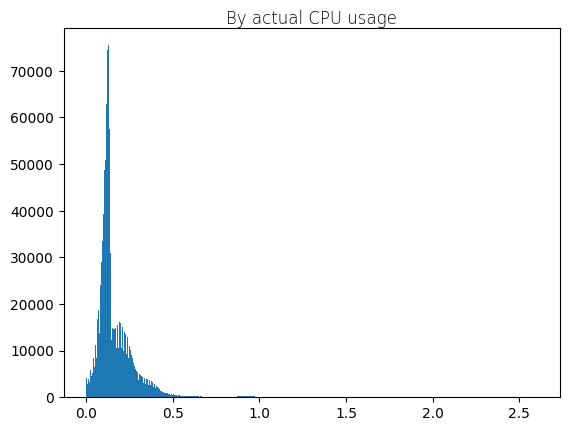

In [222]:
plotJobsDistribution(job_names_to_actual_resource_req, "By actual CPU usage")

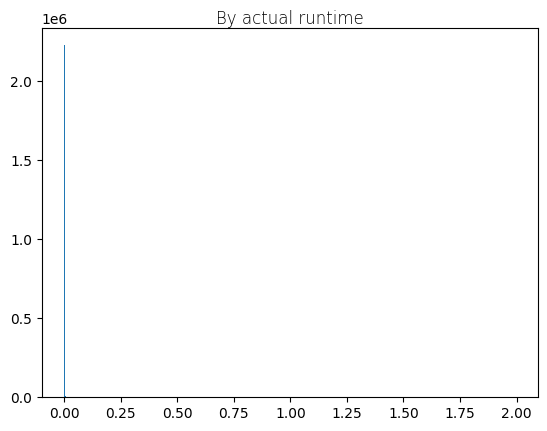

In [223]:
plotJobsDistribution(job_names_to_actual_time_req, "By actual runtime")

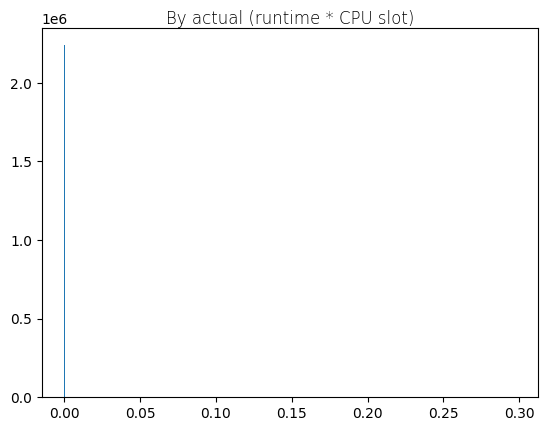

In [224]:
plotJobsDistribution(job_names_to_actual_time_resource_req, "By actual (runtime * CPU slot)")

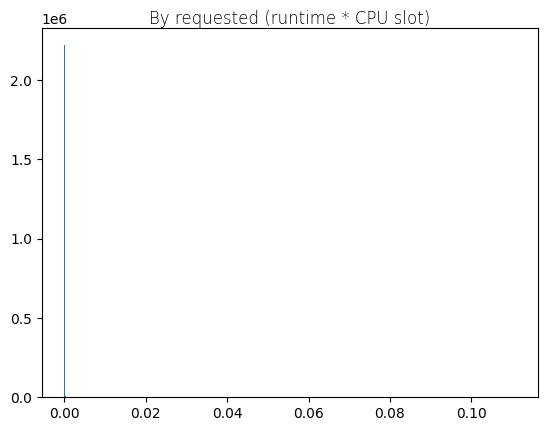

In [228]:
plotJobsDistribution(job_names_to_time_resource_req, "By requested (runtime * CPU slot)")

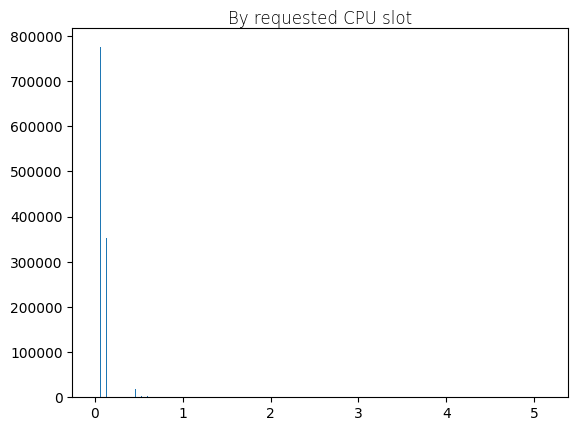

In [231]:
plotJobsDistribution(job_names_to_requested_resource_req, "By requested CPU slot")

### Creating hard, medium, easy based on CPU actual resource usage since that gave the best distribution

In [237]:
EASY_UPPER_LIMIT = 0.2
MED_UPPER_LIMIT = 0.35
easy_dags_cpu_actual_usage = []
med_dags_cpu_actual_usage = []
hard_dags_cpu_actual_usage = []

for key, val in job_names_to_actual_resource_req.items():
    if val <= EASY_UPPER_LIMIT:
        easy_dags_cpu_actual_usage.append(key)
    elif val <= MED_UPPER_LIMIT:
        med_dags_cpu_actual_usage.append(key)
    else:
        hard_dags_cpu_actual_usage.append(key)

In [238]:
print(f"DAGs split, EASY: {len(easy_dags_cpu_actual_usage)}, MEDIUM: {len(med_dags_cpu_actual_usage)}, HARD: {len(hard_dags_cpu_actual_usage)}")  

DAGs split, EASY: 1645855, MEDIUM: 456837, HARD: 150925


In [239]:
len(job_names_to_actual_resource_req)

2253617

### Select 10K dags randomly - for easy, medium, hard - and pickle them

In [241]:
def createPickleFileForDAGs(job_name_list, num_to_sample, file_name):
    sampled_dag_list = random.choices(job_name_list, k=num_to_sample)
    dags_to_pickle = {}
    for job_name in sampled_dag_list:
        dags_to_pickle[job_name] = job_names_to_tasks[job_name]
    with open(file_name, 'wb') as f:
        pickle.dump(dags_to_pickle, f)
    print('[x] Pickled {}'.format(file_name)) 

In [243]:
NUM_DAGS = 10000

createPickleFileForDAGs(easy_dags_cpu_actual_usage, NUM_DAGS, "easy_dags_cpu_actual_usage.pkl")
createPickleFileForDAGs(med_dags_cpu_actual_usage, NUM_DAGS, "med_dags_cpu_actual_usage.pkl")
createPickleFileForDAGs(hard_dags_cpu_actual_usage, NUM_DAGS, "hard_dags_cpu_actual_usage.pkl")

[x] Pickled easy_dags_cpu_actual_usage.pkl
[x] Pickled med_dags_cpu_actual_usage.pkl
[x] Pickled hard_dags_cpu_actual_usage.pkl
